# Basic examples

In this notebook we will show how to fit a model to data, in the **cosmofit** framework.
You need to have installed **cosmofit** with:
```
python -m pip install git+https://github.com/adematti/cosmofit#egg=cosmofit
```
You also need to have installed:
```
python -m pip install iminuit emcee
```
And for analytic solver:
```
pyhton -m pip install jax[cpu]
```

## Model
Let us define a simple, affine model.

In [1]:
from cosmofit.base import BaseCalculator


class AffineModel(BaseCalculator):  # all calculators should inherit from BaseCalculator

    # Model parameters; those can also be declared in a yaml file
    params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}},
              'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}
    
    def __init__(self, x=None):
        self.x = x
        self.requires = {}  # no requirement
    
    def run(self, a=0., b=0.):
        self.y = a * self.x + b  # simple, affine model
    
    # This is only needed for emulation
    def __getstate__(self):
        return {'x': self.x, 'y': self.y}  # dictionary of Python base types and numpy arrays

## Likelihood

Let us define a Gaussian likelihood.

In [2]:
import numpy as np

class Likelihood(BaseCalculator):  # all calculators should inherit from BaseCalculator
    
    def __init__(self):
        # Let us generate some fake data
        self.x = np.linspace(0., 1., 10)
        mean = np.zeros_like(self.x)
        self.covariance = np.eye(len(self.x))
        self.precision = np.linalg.inv(self.covariance)
        rng = np.random.RandomState(seed=42)
        self.y = rng.multivariate_normal(mean, self.covariance)
        # Requirements: name: {'class': ..., 'init': ...}
        self.requires = {'theory': {'class': 'AffineModel', 'init': {'x': self.x}}}
    
    @property
    def flatdiff(self):
        return self.y - self.theory.y  # requirements are accessed through .name
    
    def run(self):
        self.loglikelihood = -0.5 * self.flatdiff.dot(self.precision).dot(self.flatdiff)  # this attribute must be named loglikelihood

## Pipeline
Let us build up our likelihood pipeline, that connects the two calculators above.

In [3]:
from cosmofit import LikelihoodPipeline, setup_logging

setup_logging()  # set up logging

config = {}
# We give the likelihood a name, 'like'
# No need to specify other parameters for AffineModel, so no need to mention it
config['like'] = {'class': Likelihood}
likelihood = LikelihoodPipeline(config)

[000000.03] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found calculators [Likelihood(like), AffineModel(theory)].
[000000.03] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found end calculators [Likelihood(like)].
[000000.03] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found likelihood like.


## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [4]:
from cosmofit.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000000.05] [0/1] 10-23 19:40  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


In [5]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+-------------+--------+---------+-------+
| chi2 = 4.70 | varied | bestfit | error |
+-------------+--------+---------+-------+
|      a      |  True  |  -0.06  | 0.98  |
|      b      |  True  |  0.48   | 0.58  |
+-------------+--------+---------+-------+


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

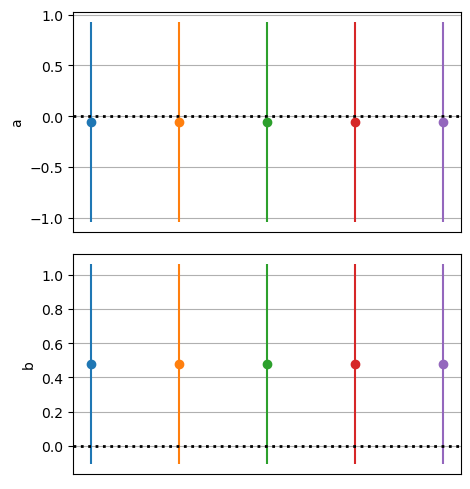

In [6]:
from cosmofit.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiler.profiles, truths=[0., 0.])

In [7]:
# Compute \Delta \chi^{2} = cl^2 = 1 interval for the best best of above best fits
profiler.interval(cl=1)
print(profiler.profiles.to_stats(tablefmt='latex_raw'))

\begin{tabular}{lllll}
\hline
 $\chi^{2} = 4.70$   & varied   & bestfit   & error   & interval             \\
\hline
 a                   & True     & $-0.06$   & $0.98$  & ${}_{-0.98}^{+0.98}$ \\
 b                   & True     & $0.48$    & $0.58$  & ${}_{-0.58}^{+0.58}$ \\
\hline
\end{tabular}


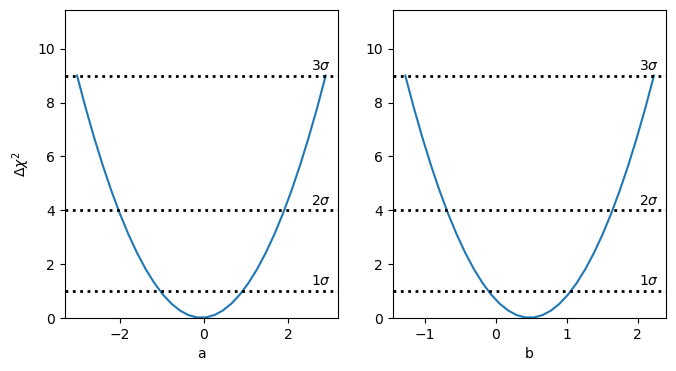

In [8]:
# Profile posterior up to cl = 3 sigmas
profiler.profile(cl=3)
# And plot, removing \chi^{2} at best fit
plotting.plot_profile(profiler.profiles, offsets=-2 * profiler.profiles.bestfit.logposterior.max())

## Analytic solver
If jax is installed (maybe we will provide an alterative relying on numpy only?), one can perform analytic marginalization over the parameters for which the model is linear.

In [9]:
from cosmofit.utils import jnp  # jax.numpy
from matplotlib import pyplot as plt


class AffineModelJax(AffineModel):  # all calculators should inherit from BaseCalculator

    def __init__(self, x=None):
        self.x = jnp.array(x)
        self.requires = {}  # no requirement

class LikelihoodWithPlot(Likelihood):

    # Just add a plotting routine
    
    def plot(self):
        ax = plt.gca()
        ax.errorbar(self.x, self.y, yerr=np.diag(self.covariance)**0.5, color='k', linestyle='none', marker='o', label='data')
        ax.plot(self.x, self.theory.y, color='r', label='theory')
        ax.grid()
        ax.legend()
        return ax

config = {}
# We give the likelihood a name, 'like'
config['like'] = {'class': LikelihoodWithPlot}
# Specify we want to analytical solve for parameter 'b'
# 'solved' can be 'best' (fixed to best fit), 'marg' (analytic marginalization)
# or 'auto', which will be 'best' in case of likelihood profiling, 'marg' in case of sampling
config['model'] = {'class': AffineModelJax, 'params': {'b': {'derived': '.auto'}}}

likelihood = LikelihoodPipeline(config)
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000003.35] [0/1] 10-23 19:40  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000003.35] [0/1] 10-23 19:40  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000003.35] [0/1] 10-23 19:40  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000003.35] [0/1] 10-23 19:40  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000003.35] [0/1] 10-23 19:40  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000003.35] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found calculators [LikelihoodWithPlot(like), AffineModelJax(model)].
[000003.36] [0/1] 10-23 19:40  LikelihoodPipe

array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

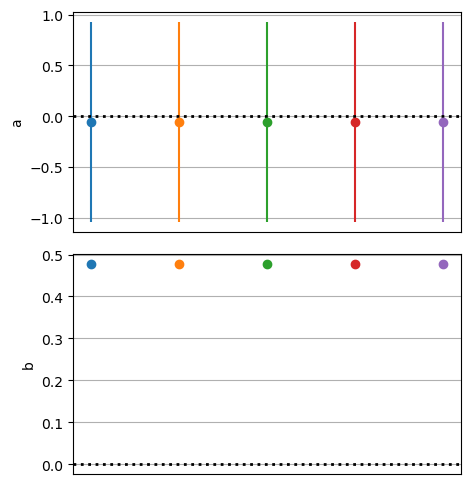

In [10]:
from cosmofit.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiler.profiles, truths=[0., 0.])

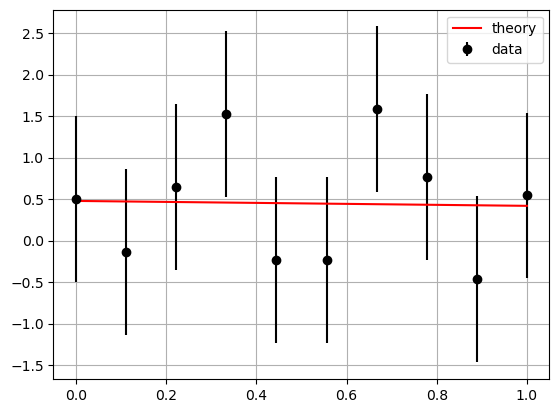

In [11]:
likelihood.run(**profiler.profiles.bestfit.choice(varied=True))
likelihood.end_calculators[0].plot()
plt.show()

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [12]:
from cosmofit.samplers import ZeusSampler

config = {}
# We give the likelihood a name, 'like'
config['like'] = {'class': LikelihoodWithPlot}

likelihood = LikelihoodPipeline(config)

# By default are running 1 chain
# We can as for me, e.g. chains=2
# MPI processes will be evenly split across all the chains
sampler = ZeusSampler(likelihood, seed=42, nwalkers=10)
# We run samples until convergence, considered reached when Gelman-Rubin (computed over 4 chain subsamples) stabilizes < 0.03; 
sampler.run(check={'max_eigen_gr': 0.03})

[000005.02] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found calculators [LikelihoodWithPlot(like), AffineModel(theory)].
[000005.02] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found end calculators [LikelihoodWithPlot(like)].
[000005.02] [0/1] 10-23 19:40  LikelihoodPipeline        INFO     Found likelihood like.
[000005.04] [0/1] 10-23 19:40  ZeusSampler               INFO     Varied parameters: ['a', 'b'].
[000005.18] [0/1] 10-23 19:40  root                      INFO     Initialising ensemble of 10 walkers...
[000028.37] [0/1] 10-23 19:40  ZeusSampler               INFO     Diagnostics:
[000028.38] [0/1] 10-23 19:40  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is -0.000636; < 0.03.
[000028.39] [0/1] 10-23 19:40  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is -0.000645.
[000028.40] [0/1] 10-23 19:40  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0819.
[000028.41] [0/1] 10-23 19:40  ZeusSa

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000051.05] [0/1] 10-23 19:41  ZeusSampler               INFO     Diagnostics:
[000051.06] [0/1] 10-23 19:41  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0293; < 0.03.
[000051.07] [0/1] 10-23 19:41  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00488.
[000051.08] [0/1] 10-23 19:41  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0194.
[000051.09] [0/1] 10-23 19:41  ZeusSampler               INFO     - max Geweke is 0.191.
[000051.09] [0/1] 10-23 19:41  ZeusSampler               INFO     - Geweke p-value is 0.332.
[000051.10] [0/1] 10-23 19:41  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 110.
[000051.10] [0/1] 10-23 19:41  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0294.


In [13]:
# If we want more samples, we can repeat run() calls, e.g.:
sampler.run(max_iterations=200)

[000051.12] [0/1] 10-23 19:41  root                      INFO     Initialising ensemble of 10 walkers...


In [14]:
# Let's remove burnin and get basic stats
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---+--------+-------+--------+------+-----------------+-----------------+
|   | argmax | mean  | median | std  | quantile:1sigma | interval:1sigma |
+---+--------+-------+--------+------+-----------------+-----------------+
| a | -0.04  | -0.01 | -0.01  | 0.96 |   -0.96/+0.95   |   -0.94/+0.96   |
| b |  0.47  | 0.44  |  0.45  | 0.57 |   -0.58/+0.57   |   -0.56/+0.58   |
+---+--------+-------+--------+------+-----------------+-----------------+


[000065.61] [0/1] 10-23 19:41  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


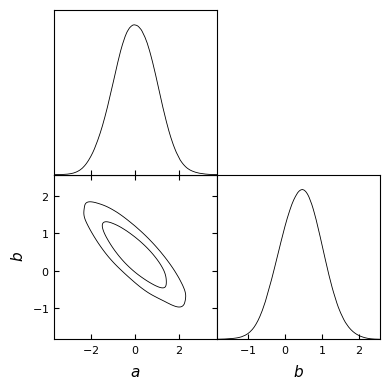

In [15]:
# This actually uses GetDist
# chain.to_getdist() will return a getdist.MCSamples object to play further
plotting.plot_triangle(chain)

## Emulate
If our model took years to run, we would likely want to emulate it. Let us try this on this simple model.

[000066.31] [0/1] 10-23 19:41  TaylorEmulator            INFO     Varied parameters: ['a', 'b'].
[000066.31] [0/1] 10-23 19:41  TaylorEmulator            INFO     Found varying ['y'] and fixed ['x'] outputs.
[000066.32] [0/1] 10-23 19:41  TaylorEmulator            INFO     Diagnostics:
[000066.33] [0/1] 10-23 19:41  BasePipeline              INFO     Found calculators [AffineModel(None)].
[000066.33] [0/1] 10-23 19:41  BasePipeline              INFO     Found end calculators [AffineModel(None)].
[000066.43] [0/1] 10-23 19:41  TaylorEmulator            INFO     - mse of y is 0 (square root = 0).
[000066.44] [0/1] 10-23 19:41  BasePipeline              INFO     Found calculators [AffineModel(None)].
[000066.44] [0/1] 10-23 19:41  BasePipeline              INFO     Found end calculators [AffineModel(None)].


array([<AxesSubplot:ylabel='y'>, <AxesSubplot:ylabel='$\\Delta$ y'>],
      dtype=object)

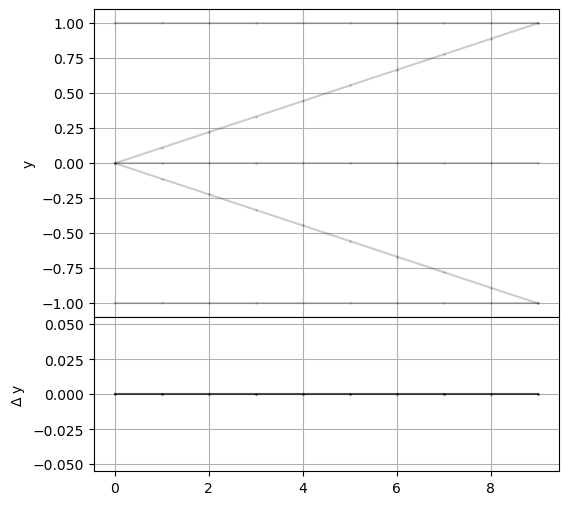

In [16]:
from cosmofit.base import BasePipeline
from cosmofit.emulators import TaylorEmulator

# We stop the pipeline to the calculator we want to emulate, i.e. theory (AffineModel)
pipeline = likelihood.select('theory', type=BasePipeline)
# Let us perform a Taylor expansion of order 1
# Attributes of AffineModel instance, obtained through theory.__getstate__()
# are automatically split between varied and fixed categories
emulator = TaylorEmulator(pipeline, order=1)
emulator.set_samples()
emulator.fit()
emulator.check()  # since model is linear, non-zero mse is just due to numerical noise
emulator.plot()  # plot some theory.y samples, and the difference emulator - model at the bottom; all good!

In [17]:
# Now dump the emulator to disk
import os

base_dir = '_tests'
fn = os.path.join(base_dir, 'emulator.npy')
emulator.save(fn)

[000066.65] [0/1] 10-23 19:41  TaylorEmulator            INFO     Saving _tests/emulator.npy.
[000066.66] [0/1] 10-23 19:41  BaseConfig                INFO     Saving _tests/emulator.yaml.


In [18]:
# A yaml file is exported, which helps recollect the parameters of the emulator
# The parameters that have been varied should be specified when using this emulator,
# other parameters (fixed) can be removed if necessary
with open(fn.replace('.npy', '.yaml')) as file:
    print(file.read())

class: AffineModel
info: {}
init:
  x: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444,
    0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888,
    1.0]
params:
  a:
    derived: false
    drop: false
    fixed: false
    latex: None
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    saved: true
    value: 0.0
  b:
    derived: false
    drop: false
    fixed: false
    latex: None
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    saved: true
    value: 0.0



In [19]:
# Now let us load our emulator into the pipeline
config = {}
config['like'] = {'class': Likelihood}
config['theory'] = {'class': 'AffineModel', 'load': fn}
likelihood = LikelihoodPipeline(config)

[000066.69] [0/1] 10-23 19:41  TaylorEmulator            INFO     Loading _tests/emulator.npy.
[000066.71] [0/1] 10-23 19:41  LikelihoodPipeline        INFO     Found calculators [Likelihood(like), AffineModel(theory)].
[000066.71] [0/1] 10-23 19:41  LikelihoodPipeline        INFO     Found end calculators [Likelihood(like)].
[000066.72] [0/1] 10-23 19:41  LikelihoodPipeline        INFO     Found likelihood like.


[000066.73] [0/1] 10-23 19:41  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

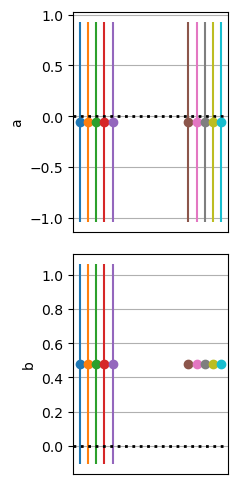

In [20]:
from cosmofit.profilers import MinuitProfiler

profiler2 = MinuitProfiler(likelihood, seed=42)
profiler2.maximize(niterations=5)
plotting.plot_aligned_stacked([profiler2.profiles, profiler.profiles], truths=True)  # truths=True will get parameter values
# Fits with the emulator and the model are the same, all good!